# Scientific Computing 3.2: Predator-prey model initial value problem
This program returns to the Lotka-Volterra predator-prey model, given by the following equations:

$$
\frac{{dR}}{{dt}} = \alpha R(t) - \beta R(t)F(t), \quad \frac{{dF}}{{dt}} = -\gamma F(t) + \delta R(t)F(t)
$$

where:
- $R(t)$: population of rabbits (the prey) over time
- $F(t)$: population of foxes (the predators) over time

The parameters are:
- $\alpha$: reproduction rate of rabbits
- $\beta$: rate at which foxes kill rabbits
- $\gamma$: fox mortality rate
- $\delta$: reproduction rate of foxes relative to rabbit abundance

In [79]:
import numpy as np
import matplotlib.pyplot as plt

### Solution of the full initial value problem
Now we solve the full transient initial value problem to find the evolution of the populations of rabbits and foxes using the following parameters:
- $\alpha = 100$
- $\beta = 1.5$
- $\gamma = 10$
- $\delta = 0.01$

From the initial condition $R(0) = 1000$, $F(0) = 100$, this program solves the Lotka–Volterra equations numerically from $t = 0$ to $t = 1$, using the following methods:

1. Forward Euler method
2. Runge-Kutta 2 (midpoint method)
3. Heun's method
4. Runge-Kutta 4
5. Backward Euler method

For each method, we plot the numerical solutions $R(t)$ and $F(t)$ versus time $t$ and create a second parametric plot showing $R(t)$ versus $F(t)$. Using the same step size $h = 0.002$ for all three methods we can compare the quality of the results.

To evaluate the system at each step, the helper functions $f(t)$ (function value at $t$) and $J(t)$ (Jacobian at $t$) are used.

### Initialization

In [80]:
alpha = 100  # rabbit reproduction rate
beta = 1.5  # fox kill rate
gamma = 10  # fox death rate
delta = 0.01  # relative fox reproduction rate

T = 1  # total simulation time
h = 0.002  # step size
N = int(np.ceil(T/h))  # number of time steps

tolx = 10**-10  # error tolerance for Newton's method in backward_euler

x = np.array([[1000], [100]])  # initial rabbit and fox population
t = h * np.arange(N+1)  # vector of time steps

### Functions

In [81]:
def f(x, a, b, g, d):  # function that returns function value of Lokta-Volterra system
    return np.array([[a*x[0, 0] - b*x[0, 0]*x[1, 0]], [d*x[0, 0]*x[1, 0] - g*x[1, 0]]])


def J(x, a, b, g, d):  # Jacobian function
    return np.array([[a-b*x[1, 0], -b*x[0, 0]], [d*x[1, 0], d*x[0, 0]-g]])


def forward_euler(x, h, N, a, b, g, d):
    result = np.zeros((x.shape[0], N+1))  # pre-allocate result array
    result[:, 0] = x[:, 0]  # store the initial state in the result array

    for i in range(N):
        x_new = x + h * f(x, a, b, g, d)
        result[:, i+1] = x_new[:, 0]  # store the new state in the result array
        x = x_new

    return result


def runge_kutta_2(x, h, N, a, b, g, d):
    result = np.zeros((x.shape[0], N+1))  # pre-allocate result array
    result[:, 0] = x[:, 0]  # store the initial state in the result array

    for i in range(N):
        k1 = f(x, a, b, g, d)
        x_half = x + h/2 * k1  # go half a step and get new f
        k2 = f(x_half, a, b, g, d)
        
        x_new = x + h * k2  # go full step with f from midpoint
        result[:, i+1] = x_new[:, 0]  # store the new state in the result array
        x = x_new

    return result


def heun_method(x, h, N, a, b, g, d):
    result = np.zeros((x.shape[0], N+1))  # pre-allocate result array
    result[:, 0] = x[:, 0]  # store the initial state in the result array

    for i in range(N):
        k1 = f(x, a, b, g, d)
        x_tmp = x + h * k1  # calculate f at new step
        k2 = f(x_tmp, a, b, g, d)
        
        x_new = x + h/2 * (k1 + k2)  # average f at old and new step
        result[:, i+1] = x_new[:, 0]  # store the new state in the result array
        x = x_new

    return result


def runge_kutta_4(x, h, N, a, b, g, d):
    result = np.zeros((x.shape[0], N+1))  # pre-allocate result array
    result[:, 0] = x[:, 0]  # store the initial state in the result array

    for i in range(N):
        k1 = f(x, a, b, g, d)
        k2 = f(x + k1 * h/2, a, b, g, d)
        k3 = f(x + k2 * h/2, a, b, g, d)
        k4 = f(x + k3 * h, a, b, g, d)

        x_new = x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        result[:, i+1] = x_new[:, 0]  # store the new state in the result array
        x = x_new

    return result


def backward_euler(x, h, N, a, b, g, d, tolx):
    result = np.zeros((x.shape[0], N+1))  # pre-allocate result array
    result[:, 0] = x[:, 0]  # store the initial state in the result array

    I = np.eye(2)  # identity matrix
    x_new = x.copy()  # use initial x as a guess for x_new

    for i in range(N):
        x = x_new.copy()  # save x_new from previous step as "old" x

        while True:
            dx = np.linalg.solve(h * J(x_new, a, b, g, d) - I, x_new - x - h * f(x_new, a, b, g, d))
            x_new = x_new + dx  # update x_new with calculated difference

            if np.linalg.norm(dx) < tolx:  # check for convergence
                break

        result[:, i+1] = x_new[:, 0]  # save converged x_new for current time step

    return result

### Main code

In [82]:
y_fe = forward_euler(x, h, N, alpha, beta, gamma, delta)
y_mp = runge_kutta_2(x, h, N, alpha, beta, gamma, delta)
y_he = heun_method(x, h, N, alpha, beta, gamma, delta)
y_rk = runge_kutta_4(x, h, N, alpha, beta, gamma, delta)
y_be = backward_euler(x, h, N, alpha, beta, gamma, delta, tolx)

### Plotting of the results
Below, the fox and rabbit polulations are plotted against time and against each other, comparing the different methods. Heun's method and the Runge-Kutta 2 method were ommited from the plots, as they almost perfectly overlap with the (more precise) Runge-Kutta 4 method.

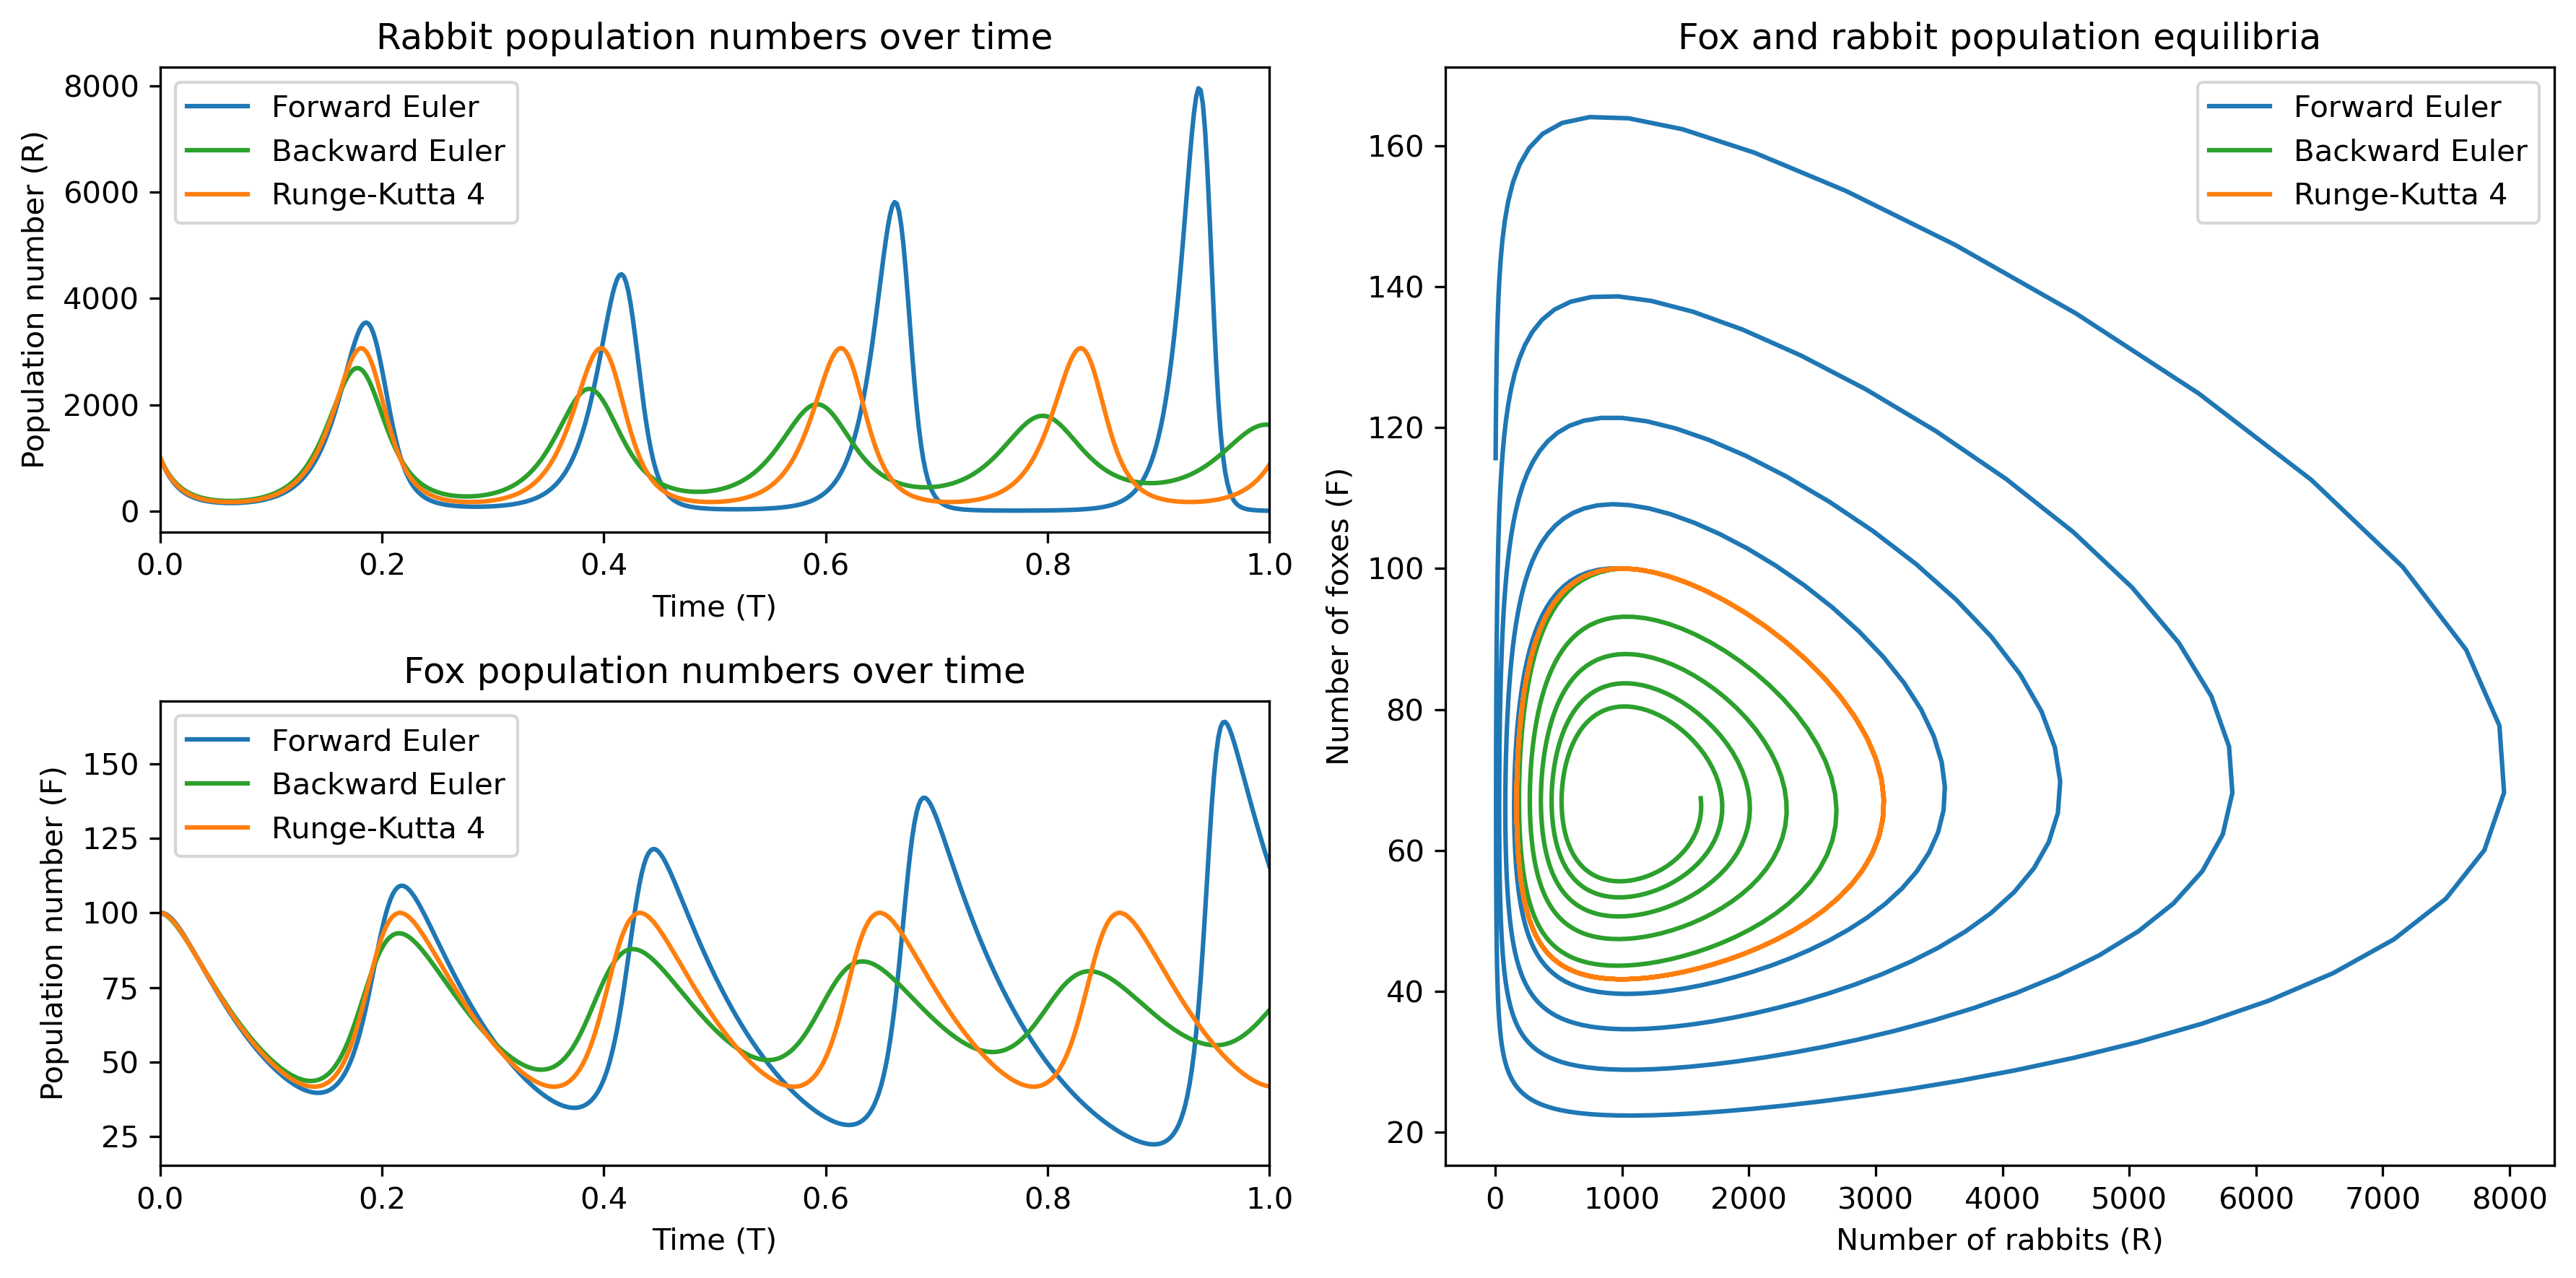

In [83]:
fig = plt.figure(figsize=(12, 6), dpi=300)

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t, (y_fe[0, :]), label="Forward Euler", color="C0")
#ax1.plot(t, (y_mp[0, :]), label="Runge-Kutta 2")
#ax1.plot(t, (y_he[0, :]), label="Heun's")
ax1.plot(t, (y_be[0, :]), label="Backward Euler", color="C2")
ax1.plot(t, (y_rk[0, :]), label="Runge-Kutta 4", color="C1")
ax1.set_title("Rabbit population numbers over time")
ax1.set_xlim(0,1)
ax1.set_xlabel(r"Time (T)")
ax1.set_ylabel("Population number (R)")
ax1.legend()

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(t, (y_fe[1, :]), label="Forward Euler", color="C0")
#ax2.plot(t, (y_mp[1, :]), label="Runge-Kutta 2")
#ax2.plot(t, (y_fe[1, :]), label="Heun's")
ax2.plot(t, (y_be[1, :]), label="Backward Euler", color="C2")
ax2.plot(t, (y_rk[1, :]), label="Runge-Kutta 4", color="C1")
ax2.set_title("Fox population numbers over time")
ax2.set_xlim(0,1)
ax2.set_xlabel("Time (T)")
ax2.set_ylabel("Population number (F)")
ax2.legend()

ax3 = fig.add_subplot(1, 2, 2)
ax3.plot(y_fe[0, :], y_fe[1, :], label="Forward Euler", color="C0")
#ax3.plot(y_mp[0, :], y_mp[1, :], label="Runge-Kutta 2")
#ax3.plot(y_he[0, :], y_he[1, :], label="Heun's")
ax3.plot(y_be[0, :], y_be[1, :], label="Backward Euler", color="C2")
ax3.plot(y_rk[0, :], y_rk[1, :], label="Runge-Kutta 4", color="C1")
ax3.set_title("Fox and rabbit population equilibria")
ax3.set_xlabel("Number of rabbits (R)")
ax3.set_ylabel("Number of foxes (F)")
ax3.legend()

plt.tight_layout()
plt.show()

It can be seen that the Forward and Backward Euler methods are inaccurate. While the Forward Euler method is instable and would lead to ever-larger population number fluctuations, the Backward Euler method is stable, but inaccurate. The Runge-Kutta 4 method shows an accurate solution of the Lotka-Volterra system over time.